<a href="https://colab.research.google.com/github/NickSlm/all-for-one/blob/main/machine-learning/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
(X_train_full, y_train_full),(X_test, y_test) = keras.datasets.cifar10.load_data()

In [ ]:
X_train, y_train = X_train_full[5000:], y_train_full[5000:]
X_val, y_val = X_train_full[:5000], y_train_full[:5000]

X_train = X_train.astype(np.float32) / 255
X_val = X_val.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255

In [ ]:
sample_images = X_train[:8]

In [ ]:
def plot_image(images, n_rows=4):
    n_images = images.shape[0]
    figure = plt.figure(figsize=(8.4, 8.4))
    for i in range(n_images):
        figure.add_subplot(n_rows, n_images // n_rows + 1, i + 1)
        plt.imshow(images[i])
        plt.axis("off")
    plt.show()

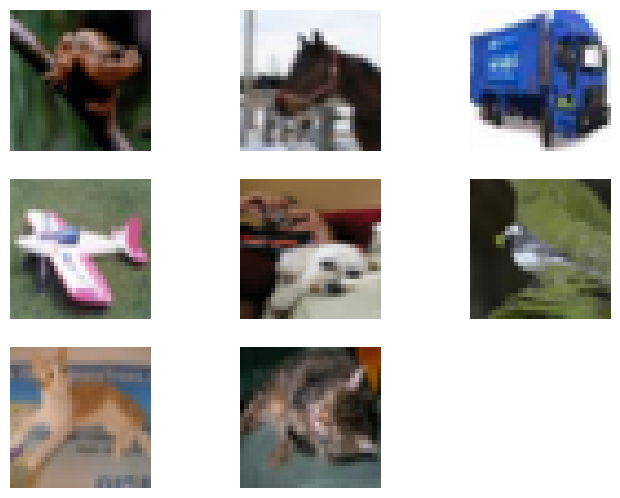

In [ ]:
plot_image(sample_images)

In [ ]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
  generator, discriminator = gan.layers
  for epoch in range(n_epochs):
    print(f"Epoch {epoch + 1}/{n_epochs}")
    for X_batch in dataset:
      noise = tf.random.normal(shape=[batch_size, codings_size])
      generated_images = generator(noise)
      X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
      y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
      discriminator.trainable = True
      discriminator.train_on_batch(X_fake_and_real, y1)

      noise = tf.random.normal(shape=[batch_size, codings_size])
      y2 = tf.constant([[1.]] * batch_size)
      discriminator.trainable = False
      gan.train_on_batch(noise, y2)
    plot_image(generated_images, 6)

In [ ]:
INPUT_SHAPE = [32, 32, 3]
BATCH_SIZE = 32
CODINGS_DIM = 100

In [ ]:
generator = keras.models.Sequential([
    keras.layers.Input(shape=[CODINGS_DIM]),
    keras.layers.Dense(4*4*64),
    keras.layers.Reshape([4,4,64]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(3, kernel_size=3, strides=2, padding="SAME", activation="tanh")
])

discriminator = keras.models.Sequential([
    keras.layers.Input(shape=INPUT_SHAPE),
    keras.layers.Conv2D(64, kernel_size=3, strides=2, padding="SAME", activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=3, strides=2, padding="SAME", activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(256, kernel_size=3, strides=2, padding="SAME", activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])

gan = keras.models.Sequential([generator, discriminator])

In [ ]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [ ]:
X_train_dcgan = X_train.reshape(-1, 32, 32, 3) * 2. -1
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

Epoch 1/2


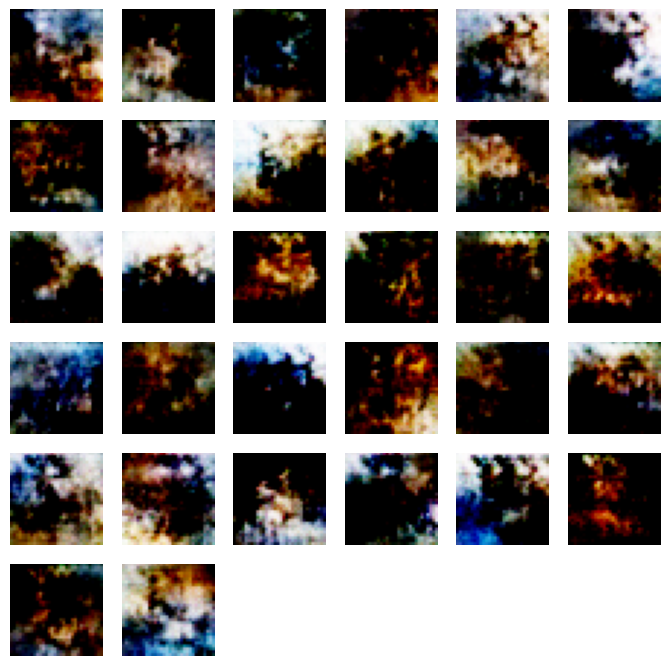

Epoch 2/2


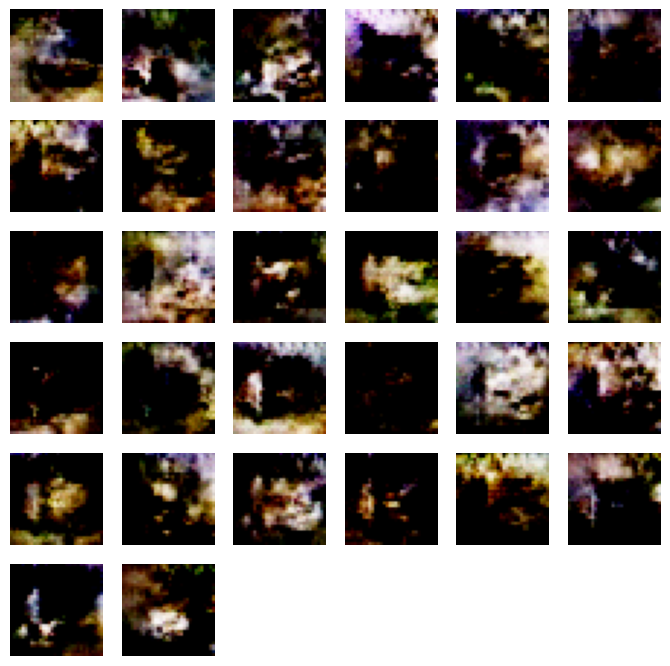

In [ ]:
train_gan(gan, dataset, BATCH_SIZE, CODINGS_DIM, n_epochs=2)